# `bw_timex` Teaching Exercise - Time-explicit LCA of an Electric Vehicle vs Petrol Vehicle. SOLUTION NOTEBOOK

In this exercise notebook you will compare the climate preformance of a battery electric vehicle (BEV) and an internal combustion engine (ICE) car, in a time explicit way, using in different decarbonisation scenarios. 

In order to have a fair comparison**, we will start from two existing ecoinvent activities (listed below) and will add the temporal information as needed. This notebook will guide you through the steps needed to build the model. But if you are you can either ask the instructors or have a look at the solution notebook (Note that this just provides one solution, and there are often multiple ways to get to the same result, so we encourage you to use the way that is most intuative to you!). 

At the end of this notebook there are a few bonus questions. 


** Warning: Any LCA is only every as good as the underlying data. the data on cars in Ecoinvent is really outdated (check the description/comment of the activities to get an idea about the data), so the results from this exercise should be interpreted with care, as should any LCA result be of course!




In [1]:
# first we need to load the correct Brightway2 project with the required databases
import bw2data as bd
import bw2io as bi


project_name = "Timex_teaching_ei310"

# let's make sure to start fresh
if project_name in bd.projects:
    print(f"Project '{project_name}' already exists. Deleting it for fresh import.")
    bd.projects.delete(project_name)


bi.backup.restore_project_directory(fp= '/Users/ajakobs/Documents/prospective_dynamic_lca/brightway2-project-Timex_teaching_ei310-backup08-October-2025-05-15PM.tar.gz',
                                    overwrite_existing=True)



/Users/ajakobs/miniconda3/envs/timex_new/lib/python3.11/site-packages/scikits/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__('pkg_resources').declare_namespace(__name__)


In [3]:
# check the databases present
print(bd.databases)

Databases dictionary with 11 object(s):
	ecoinvent-3.10-biosphere
	ecoinvent-3.10-cutoff
	ei_cutoff_3.10_remind-eu_SSP2-NPi_2020 2025-10-08
	ei_cutoff_3.10_remind-eu_SSP2-NPi_2030 2025-10-08
	ei_cutoff_3.10_remind-eu_SSP2-NPi_2040 2025-10-08
	ei_cutoff_3.10_remind-eu_SSP2-NPi_2050 2025-10-08
	ei_cutoff_3.10_remind-eu_SSP2-PkBudg650_2020 2025-10-08
	ei_cutoff_3.10_remind-eu_SSP2-PkBudg650_2030 2025-10-08
	ei_cutoff_3.10_remind-eu_SSP2-PkBudg650_2040 2025-10-08
	ei_cutoff_3.10_remind-eu_SSP2-PkBudg650_2050 2025-10-08
	foreground


## Prospective background databases

We used `premise` to create two different sets of 'ecoinvent-databases' representing two different carbonisation pathways. They are the based on the REMIND-EU IAM for the SSP2 scenario in combination with Paris Agreement consistent policies (PkBud650) as an (very) optimistic scenario, and the 'national policies implemented' (NPi) as a business as usual (BAU) scenario:

- REMIND-EU - SSP2-NPi       : BAU scenario with ~3˚ warming by 2100
- REMIND-EU - SSP2-PkBudg650 : Optimistic scenario in line with Paris 2015 with 1.5˚-1.9˚ warming bby 2100

(See [the Premise documentation](https://premise.readthedocs.io/en/latest/introduction.html#default-iam-scenarios) for a brief overview of the IAM scenarios) 



In [4]:
# Let's get easy handles for the databases for ease of use:
# National Policies and Implemention (NPi) scenario
db_2020_NPi = bd.Database("ei_cutoff_3.10_remind-eu_SSP2-NPi_2020 2025-10-08")
db_2030_NPi = bd.Database("ei_cutoff_3.10_remind-eu_SSP2-NPi_2030 2025-10-08")
db_2040_NPi = bd.Database("ei_cutoff_3.10_remind-eu_SSP2-NPi_2040 2025-10-08")
db_2050_NPi = bd.Database("ei_cutoff_3.10_remind-eu_SSP2-NPi_2050 2025-10-08")

In [6]:
# Peak-Budget 650 scenario
db_2020_PkBudg650 = bd.Database("ei_cutoff_3.10_remind-eu_SSP2-PkBudg650_2020 2025-10-08")
db_2030_PkBudg650 = bd.Database("ei_cutoff_3.10_remind-eu_SSP2-PkBudg650_2030 2025-10-08")
db_2040_PkBudg650 = bd.Database("ei_cutoff_3.10_remind-eu_SSP2-PkBudg650_2040 2025-10-08")
db_2050_PkBudg650 = bd.Database("ei_cutoff_3.10_remind-eu_SSP2-PkBudg650_2050 2025-10-08")

## Case study setup

In this exercise we will go about setting up the forground system in a slightly different way. In our case driving a(n electric) car is already represented in ecoinvent. So all we would need to do is to add the temporal distributions to the exchanges. In the current implementation of `bw_timex`, all activities 
containing temporal information on the exchanges need to 'live' in the foreground system, so that their inputs can get linked to different background activities.

Let's start the definition of our functional unit (FU): 

- Driving a passenger car for 200,000km (including production, EoL treatment, maintenance, etc), over a period of 15 years.


### Modeling the production system

As a first step of modelling the production system let's create a new foreground database:


In [7]:
fg_db_name = "foreground"

if fg_db_name in bd.databases:
    del bd.databases[fg_db_name] # to make sure we create the foreground from scratch
# foreground = bd.Database(fg_db_name)
# foreground.register()

In [8]:
foreground = bd.Database(fg_db_name)
foreground.register()

And let's define the FU relevant quantities: 

In [10]:
LIFETIME_KM = 200000.  # lifetime of the vehicle in km
LIFETIME = 15  # lifetime of the vehicle in years
ANNUAL_KM = LIFETIME_KM / LIFETIME  # annual km

Now let's create two activities in the foreground that represent the functional units as defined above (production/driving/EoL treatment of a car for 200,000km over 15 years). We can call them LC_BEV and LC_ICEC for example (LC=life cyle)

In [11]:
LC_BEV = foreground.new_node("lc_bev", name="Life cycle of a BEV", unit="unit")
LC_BEV['reference product'] = "LC_BEV"
LC_BEV.save()

LC_ICEC = foreground.new_node("lc_icec", name="Life cycle of a internal combustion engine car")
LC_ICEC['reference product'] = "LC_ICEC"
LC_ICEC.save()


Let's make a simplified overview of the activities at every step (example for the ICEC). So far we only have defined the lifecycle activity:
in the foreground. We will use different colours for the foreground and backgroudn processes. 

```{mermaid}
flowchart LR
    LC_ICEC(Life Cycle ICEC):::fg

    classDef ei color:#222832, fill:#3fb1c5, stroke:none;
    classDef fg color:#222832, fill:#9c5ffd, stroke:none;

```
Legend:
```{mermaid}
flowchart TD
    foreground(Foreground process):::fg 
    background(Background process):::ei

    classDef ei color:#222832, fill:#3fb1c5, stroke:none;
    classDef fg color:#222832, fill:#9c5ffd, stroke:none;

```


Ecoinvent already contains activities that represent transport with a passenger car. So let's get the following two activities from the base database** for the BAU scenario and create a copy in our foreground database:

- Driving a gasoline car: "transport, passenger car, gasoline, Medium SUV, EURO-6"
- Driving a BEV: "transport, passenger car, gasoline, Medium SUV, EURO-6"

The idea is to first see how these activities are set up. It might help to draw your own system definition to create an overview of the exchnages and to which you want to add temporal information. The following steps guide you through the process. 

HINT: their are multiple locations of this activity in the premise database, choose one of your liking/or that makes sense for you.
HINT: copy to a different database by first copying the activity and then changing the database.

** We consider that as our base year and db_2020 as the 'base' database

In [13]:
# only run this cell once!
driving_icec = db_2020_NPi.get(name='transport, passenger car, gasoline, Medium SUV, EURO-6', location="RER").copy()
driving_icec['database'] = fg_db_name
driving_bev = db_2020_NPi.get(name='transport, passenger car, battery electric, Medium SUV', location="RER").copy()
driving_bev['database'] = fg_db_name

Successfully switch activity dataset to database `foreground`
Successfully switch activity dataset to database `foreground`


The Reference product of these activities should be 1 km traveled by the resepctive vehicle, but let's check the reference product and its unit:

In [14]:
print(f'Driving BEV reference product: {driving_bev.rp_exchange()}')
print(f'Driving BEV rp unit: {driving_bev.rp_exchange()["unit"]}')
print(f'Driving ICEC reference product: {driving_icec.rp_exchange()}')
print(f'Driving ICEC rp unit: {driving_icec.rp_exchange()["unit"]}')

Driving BEV reference product: Exchange: 1.0 kilometer 'transport, passenger car, battery electric, Medium SUV' (kilometer, RER, None) to 'transport, passenger car, battery electric, Medium SUV' (kilometer, RER, None)>
Driving BEV rp unit: kilometer
Driving ICEC reference product: Exchange: 1.0 kilometer 'transport, passenger car, gasoline, Medium SUV, EURO-6' (kilometer, RER, None) to 'transport, passenger car, gasoline, Medium SUV, EURO-6' (kilometer, RER, None)>
Driving ICEC rp unit: kilometer


Have a look at what the inputs into such a car is and identify the relevant exchanges:

In [15]:
[exc for exc in driving_bev.technosphere()]

[Exchange: 1.0032746104116086e-05 unit 'maintenance, passenger car' (unit, RER, None) to 'transport, passenger car, battery electric, Medium SUV' (kilometer, RER, None)>,
 Exchange: -8.875493222149089e-06 kilogram 'market for brake wear emissions, passenger car' (kilogram, GLO, None) to 'transport, passenger car, battery electric, Medium SUV' (kilometer, RER, None)>,
 Exchange: 6.330434644041816e-06 kilogram 'market for refrigerant R134a' (kilogram, GLO, None) to 'transport, passenger car, battery electric, Medium SUV' (kilometer, RER, None)>,
 Exchange: 0.0010772707173600793 meter-year 'market for road' (meter-year, GLO, None) to 'transport, passenger car, battery electric, Medium SUV' (kilometer, RER, None)>,
 Exchange: 0.001290000043809414 meter-year 'market for road maintenance' (meter-year, RER, None) to 'transport, passenger car, battery electric, Medium SUV' (kilometer, RER, None)>,
 Exchange: -1.896191679406911e-05 kilogram 'market for road wear emissions, passenger car' (kilog

In [50]:
[exc for exc in driving_icec.technosphere()]

[Exchange: 7.640378498763312e-06 unit 'maintenance, passenger car' (unit, RER, None) to 'transport, passenger car, gasoline, Medium SUV, EURO-6' (kilometer, RER, None)>,
 Exchange: -1.4271368854679167e-05 kilogram 'market for brake wear emissions, passenger car' (kilogram, GLO, None) to 'transport, passenger car, gasoline, Medium SUV, EURO-6' (kilometer, RER, None)>,
 Exchange: 6.330434644041816e-06 kilogram 'market for refrigerant R134a' (kilogram, GLO, None) to 'transport, passenger car, gasoline, Medium SUV, EURO-6' (kilometer, RER, None)>,
 Exchange: 0.0008383162785321474 meter-year 'market for road' (meter-year, GLO, None) to 'transport, passenger car, gasoline, Medium SUV, EURO-6' (kilometer, RER, None)>,
 Exchange: 0.001290000043809414 meter-year 'market for road maintenance' (meter-year, RER, None) to 'transport, passenger car, gasoline, Medium SUV, EURO-6' (kilometer, RER, None)>,
 Exchange: -1.5723269825684838e-05 kilogram 'market for road wear emissions, passenger car' (kilo

LEt's make a simplified overview of these activities so far (example for the ICEC): 

```{mermaid}
flowchart LR
    passenger_icec(Passenger car, gasoline, ...):::ei-->transport_icec
    petrol(Market for Petrol, ...):::ei-->transport_icec
    maintenance_wear(Maintenance and wear):::ei-->transport_icec
    transport_icec(Driving an ICEC):::fg -.-> lc_icec(Life Cycle ICEC):::fg
    
    

    classDef ei color:#222832, fill:#3fb1c5, stroke:none;
    classDef fg color:#222832, fill:#9c5ffd, stroke:none;
```

Where the dotted line indicates that we have not made this connection yet. 

These 'transport activities' include both the car, which in itself contains both production and EoL treatment (check this!!), as well as the fuel/electricity, maintenance and wear etc. Now we want to model the production and EoL treatment of car and it's elements separately so let's make a copy of these activities in the foreground so that we can add temporal distributions to the production and EoL.

At the same time we want to split the driving and production/EoL so set the input of the car into the driving activity to 0 to avoid double counting.

In [17]:
# first copy the activities production/EoL treatment of the cars into the foreground
bev_production_eol = db_2020_NPi.get(name='passenger car, battery electric, Medium SUV').copy()
bev_production_eol['database'] = fg_db_name

icec_production_eol = db_2020_NPi.get(name='Passenger car, gasoline, Medium SUV, EURO-6d').copy()
icec_production_eol['database'] = fg_db_name


Successfully switch activity dataset to database `foreground`
Successfully switch activity dataset to database `foreground`


Have a look at the exchanges of the production/EoL activity and see that these indeed include both production and EoL.


In [18]:
for exc in bev_production_eol.technosphere():
    print(exc)

Exchange: 55.0 kilowatt hour 'market for battery capacity (MIX scenario)' (kilowatt hour, GLO, None) to 'passenger car, battery electric, Medium SUV' (unit, RER, None)>
Exchange: 196.0 kilogram 'glider lightweighting' (kilogram, GLO, None) to 'passenger car, battery electric, Medium SUV' (unit, RER, None)>
Exchange: 5.960869789123535 kilogram 'market for charger, electric passenger car' (kilogram, GLO, None) to 'passenger car, battery electric, Medium SUV' (unit, RER, None)>
Exchange: 4.470652103424072 kilogram 'market for converter, for electric passenger car' (kilogram, GLO, None) to 'passenger car, battery electric, Medium SUV' (unit, RER, None)>
Exchange: 89.32574462890625 kilogram 'market for electric motor, electric passenger car' (kilogram, GLO, None) to 'passenger car, battery electric, Medium SUV' (unit, RER, None)>
Exchange: 1400.0 kilogram 'market for glider, passenger car' (kilogram, GLO, None) to 'passenger car, battery electric, Medium SUV' (unit, RER, None)>
Exchange: 89

In [19]:
# now set the input of the car into the driving activity to 0 to avoid double counting
for exc in driving_bev.technosphere():
    if exc.input['name'] == 'passenger car, battery electric, Medium SUV':
        exc.delete()
        break
for exc in driving_icec.technosphere():
    if exc.input['name'] == 'Passenger car, gasoline, Medium SUV, EURO-6d':
        exc.delete()
        break

So now update our overview:

```{mermaid}
flowchart LR
    petrol(Market for Petrol, ...):::ei-->transport_icec
    maintenance_wear(Maintenance and wear):::ei-->transport_icec
    transport_icec(Driving an ICEC):::fg -.-> lc_icec(Life Cycle ICEC):::fg
    passenger_icec(Passenger car, gasoline, ...):::fg-.->lc_icec
    production_icec(Production ICEC):::ei-->passenger_icec
    eol_icec(EoL treatment ICEC):::ei-->passenger_icec
    

    classDef ei color:#222832, fill:#3fb1c5, stroke:none;
    classDef fg color:#222832, fill:#9c5ffd, stroke:none;
```

Where the dotted line indicates that we have not made this connection yet. 

### Adding the relevant exchanges and temporal information

Now it is time to add the relevant exchanges to the functional unit activities together with relevant temporal distributions. Be carefull to add the temporal distribution to poduction and EoL at the right exchnage, so that production happens before the use phase but EoL after the use phase. 

Tipp: for ease of use, or if you forgot how to define temporal distributions you can use the interactive_td_widget!

Tipp 2: Use the utility function add_temporal_distribution_to_exchange to add the temporal distribution to the EoL of the production/EoL activity of the cars. 


Let's first draw the system we want including where we want TD's


```{mermaid}
flowchart LR
    petrol(Market for Petrol, ...):::ei-->transport_icec
    maintenance_wear(Maintenance and wear):::ei-->transport_icec
    transport_icec(Driving an ICEC):::fg ==>|Temporal information|lc_icec(Life Cycle ICEC):::fg
    passenger_icec(Passenger car, gasoline, ...):::fg==>|Temporal information|lc_icec
    production_icec(Production ICEC):::ei-->passenger_icec
    eol_icec(EoL treatment ICEC):::ei==>|Temporal information|passenger_icec
    

    classDef ei color:#222832, fill:#3fb1c5, stroke:none;
    classDef fg color:#222832, fill:#9c5ffd, stroke:none;
```




In [ ]:
# some relevant imports
from bw_timex.utils import interactive_td_widget
from bw_timex.utils import add_temporal_distribution_to_exchange
from bw_temporalis import easy_timedelta_distribution

In [21]:
interactive_td_widget()

In [22]:
LC_BEV.new_edge(input=LC_BEV, amount=1, type='production').save()
LC_BEV.new_edge(input=driving_bev, amount=LIFETIME_KM, type='technosphere').save()
LC_BEV.new_edge(input=bev_production_eol, amount=1, type='technosphere').save()

LC_ICEC.new_edge(input=LC_ICEC, amount=1, type='production').save()
LC_ICEC.new_edge(input=driving_icec, amount=LIFETIME_KM, type='technosphere').save()
LC_ICEC.new_edge(input=icec_production_eol, amount=1, type='technosphere').save()

In [23]:
# now define and add the temporal distributions to the relevant exchanges
# for the production of the cars, we assume a uniform distribution over 5 years prior to use
# for the use phase, we assume a uniform distribution over the lifetime of the car (15 years)
# for the EoL, a fixed point in time at the end of the lifetime + 1 year

td_driving =  easy_timedelta_distribution(
    start=0,
    end=15,
    resolution='Y',
    steps=16,
    kind='uniform'
)

td_production = easy_timedelta_distribution(
    start=-5,
    end=-1,
    resolution='Y',
    steps=6,
    kind='uniform'
)

import numpy as np
from bw_temporalis import TemporalDistribution

date = np.array([16], dtype='timedelta64[Y]')
amount = np.array([1], dtype=float)
td_eol = TemporalDistribution(date=date, amount=amount)


add_temporal_distribution_to_exchange(td_driving,
                                      input_node=driving_bev,
                                      output_node=LC_BEV
                                      )
add_temporal_distribution_to_exchange(td_driving,
                                      input_node=driving_icec,
                                      output_node=LC_ICEC
                                      )

/Users/ajakobs/miniconda3/envs/timex_new/lib/python3.11/site-packages/bw_temporalis/utils.py:194: UserWarning: More steps than discrete possibilities (6 versus 5).
    Values will be duplicated due to rounding.
  warnings.warn(MESSAGE)
2025-10-09 10:44:09.209 | INFO     | bw_timex.utils:add_temporal_distribution_to_exchange:472 - Added temporal distribution to exchange Exchange: 200000.0 kilometer 'transport, passenger car, battery electric, Medium SUV' (kilometer, RER, None) to 'Life cycle of a BEV' (unit, GLO, None)>.
2025-10-09 10:44:09.212 | INFO     | bw_timex.utils:add_temporal_distribution_to_exchange:472 - Added temporal distribution to exchange Exchange: 200000.0 kilometer 'transport, passenger car, gasoline, Medium SUV, EURO-6' (kilometer, RER, None) to 'Life cycle of a internal combustion engine car' (None, GLO, None)>.


In [24]:
# Now we add the temporal distributions for production and end of life to the exchanges of the 
# production/EoL activities of the cars. Here we will make use of the fact that in ecoinvent waste treatment
# activities are modelled as negative inputs. 

for exc in bev_production_eol.technosphere():
    if exc['amount'] >= 0:  # production
        add_temporal_distribution_to_exchange(td_production,
                                              input_node=exc.input,
                                              output_node=exc.output)
    else:  # EoL
        add_temporal_distribution_to_exchange(td_eol,
                                              input_node=exc.input,
                                              output_node=exc.output)
for exc in icec_production_eol.technosphere():
    if exc['amount'] >= 0:  # production
        add_temporal_distribution_to_exchange(td_production,
                                              input_node=exc.input,
                                              output_node=exc.output)
    else:  # EoL
        add_temporal_distribution_to_exchange(td_eol,
                                              input_node=exc.input,
                                              output_node=exc.output)

2025-10-09 10:44:09.539 | INFO     | bw_timex.utils:add_temporal_distribution_to_exchange:472 - Added temporal distribution to exchange Exchange: 55.0 kilowatt hour 'market for battery capacity (MIX scenario)' (kilowatt hour, GLO, None) to 'passenger car, battery electric, Medium SUV' (unit, RER, None)>.
2025-10-09 10:44:09.544 | INFO     | bw_timex.utils:add_temporal_distribution_to_exchange:472 - Added temporal distribution to exchange Exchange: 196.0 kilogram 'glider lightweighting' (kilogram, GLO, None) to 'passenger car, battery electric, Medium SUV' (unit, RER, None)>.
2025-10-09 10:44:09.548 | INFO     | bw_timex.utils:add_temporal_distribution_to_exchange:472 - Added temporal distribution to exchange Exchange: 5.960869789123535 kilogram 'market for charger, electric passenger car' (kilogram, GLO, None) to 'passenger car, battery electric, Medium SUV' (unit, RER, None)>.
2025-10-09 10:44:09.552 | INFO     | bw_timex.utils:add_temporal_distribution_to_exchange:472 - Added tempora

### Checking all went right

Now before calculating the time-explicit LCA, make sure that everything went right so far. As a check, the standard LCA score of the original transport activity with the corresponding amount should be equal the standard LCA of the modified life cycle activity created in the foreground!

In [25]:
import bw2calc as bc

# standard LCA of the original transport activity with the corresponding amount
transport_icec= db_2020_NPi.get(name='transport, passenger car, gasoline, Medium SUV, EURO-6', location="RER")
method = ('ecoinvent-3.10', 'EF v3.1', 'climate change', 'global warming potential (GWP100)')
lca = bc.LCA({transport_icec: LIFETIME_KM}, method)
lca.lci()
lca.lcia()
print(f'Life cycle impact score: {lca.score} kg CO2-eq for {LIFETIME_KM} km driving with ICEC')

# standard LCA of the modified life cycle activity created in the foreground
lca_fg = bc.LCA({LC_ICEC: 1}, method)
lca_fg.lci()
lca_fg.lcia()
print(f'Life cycle impact score: {lca_fg.score} kg CO2-eq for {LIFETIME_KM} km driving with ICEC')

/Users/ajakobs/miniconda3/envs/timex_new/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 6.53e+12)
  warnings.warn(msg, UmfpackWarning)


Life cycle impact score: 59312.39430285427 kg CO2-eq for 200000.0 km driving with ICEC
Life cycle impact score: 59312.39458546932 kg CO2-eq for 200000.0 km driving with ICEC


In [26]:
# now the same for the BEV
# standard LCA of the original transport activity with the corresponding amount
transport_bev = db_2020_NPi.get(name='transport, passenger car, battery electric, Medium SUV', location="RER")
lca_bev = bc.LCA({transport_bev: LIFETIME_KM}, method)
lca_bev.lci()
lca_bev.lcia()
print(f'Life cycle impact score: {lca_bev.score} kg CO2-eq for {LIFETIME_KM} km driving with BEV')  

# standard LCA of the modified life cycle activity created in the foreground
lca_bev_fg = bc.LCA({LC_BEV: 1}, method)
lca_bev_fg.lci()
lca_bev_fg.lcia()
print(f'Life cycle impact score: {lca_bev_fg.score} kg CO2-eq for {LIFETIME_KM} km driving with BEV')

Life cycle impact score: 45363.17175278414 kg CO2-eq for 200000.0 km driving with BEV
Life cycle impact score: 45363.172195333136 kg CO2-eq for 200000.0 km driving with BEV


## Time-explicit LCA with `bw_timex`

Now we can start using `bw_timex` to build the process timeline, build the time-explicit inventory and calculate the time explicit scores.

Start by creating a dictionary mapping the respective databases to the relevant timestamps. 
Then instantiate your timexLCA object, build the timeline, calculate the lci, and the LCIA for both options.


In [27]:
from datetime import datetime

database_dates = {
    db_2020_NPi.name: datetime.strptime("2020", "%Y"),
    db_2030_NPi.name: datetime.strptime("2030", "%Y"),
    db_2040_NPi.name: datetime.strptime("2040", "%Y"),
    db_2050_NPi.name: datetime.strptime("2050", "%Y"),
    "foreground": "dynamic", # flag databases that should be temporally distributed with "dynamic"
}

In [28]:
from bw_timex import TimexLCA

In [29]:
tlca_BEV = TimexLCA({LC_BEV: 1}, method, database_dates)
tlca_BEV.build_timeline(temporal_grouping="year")  # build timeline with yearly steps

2025-10-09 10:44:36.665 | INFO     | bw_timex.timex_lca:__init__:114 - Initializing TimexLCA object...
2025-10-09 10:44:36.665 | INFO     | bw_timex.timex_lca:__init__:136 - Collecting node infos...
2025-10-09 10:44:42.731 | INFO     | bw_timex.timex_lca:build_timeline:216 - No edge filter function provided. Skipping all edges in background databases.
2025-10-09 10:44:45.933 | INFO     | bw_timex.timex_lca:build_timeline:232 - Calculating base LCA...
/Users/ajakobs/miniconda3/envs/timex_new/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 3.71e+13)
  warnings.warn(msg, UmfpackWarning)
2025-10-09 10:44:48.162 | INFO     | bw_timex.timex_lca:build_timeline:242 - Creating activity time mapping...
2025-10-09 10:44:48.426 | INFO     | bw_timex.timeline_builder:__init__:99 - Traversing supply chain graph...


Starting graph traversal


2025-10-09 10:45:16.227 | INFO     | bw_timex.timeline_builder:build_timeline:142 - Building timeline...


Calculation count: 21


,date_producer,producer_name,date_consumer,consumer_name,amount,temporal_market_shares
0,2021-01-01,"market for glider, passenger car",2026-01-01,"passenger car, battery electric, Medium SUV",233.333333,{'ei_cutoff_3.10_remind-eu_SSP2-NPi_2020 2025-...
1,2021-01-01,"market for power distribution unit, for electr...",2026-01-01,"passenger car, battery electric, Medium SUV",0.662319,{'ei_cutoff_3.10_remind-eu_SSP2-NPi_2020 2025-...
2,2021-01-01,"market for inverter, for electric passenger car",2026-01-01,"passenger car, battery electric, Medium SUV",1.490217,{'ei_cutoff_3.10_remind-eu_SSP2-NPi_2020 2025-...
3,2021-01-01,"market for charger, electric passenger car",2026-01-01,"passenger car, battery electric, Medium SUV",0.993478,{'ei_cutoff_3.10_remind-eu_SSP2-NPi_2020 2025-...
4,2021-01-01,"market for converter, for electric passenger car",2026-01-01,"passenger car, battery electric, Medium SUV",0.745109,{'ei_cutoff_3.10_remind-eu_SSP2-NPi_2020 2025-...
...,...,...,...,...,...,...
146,2041-01-01,market for road,2041-01-01,"transport, passenger car, battery electric, Me...",0.001077,{'ei_cutoff_3.10_remind-eu_SSP2-NPi_2040 2025-...
147,2041-01-01,"market group for electricity, low voltage",2041-01-01,"transport, passenger car, battery electric, Me...",0.262637,{'ei_cutoff_3.10_remind-eu_SSP2-NPi_2040 2025-...
148,2042-01-01,"treatment of used internal combustion engine, ...",2026-01-01,"passenger car, battery electric, Medium SUV",-89.417404,{'ei_cutoff_3.10_remind-eu_SSP2-NPi_2040 2025-...
149,2042-01-01,market for used powertrain from electric passe...,2026-01-01,"passenger car, battery electric, Medium SUV",-112.672485,{'ei_cutoff_3.10_remind-eu_SSP2-NPi_2040 2025-...


In [30]:
tlca_BEV.lci()  # calculate the dynamic inventory
tlca_BEV.dynamic_lcia(metric="GWP", fixed_time_horizon=True)  # calculate the dynamic LCIA for GWP100

2025-10-09 10:45:16.840 | INFO     | bw_timex.timex_lca:lci:360 - Expanding matrices...
2025-10-09 10:45:16.930 | INFO     | bw_timex.timex_lca:lci:379 - Calculating dynamic inventory...
/Users/ajakobs/miniconda3/envs/timex_new/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex_new/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.42e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex_new/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.42e+12)
  warnings.warn(msg, UmfpackWarning)
2025-10-09 10:45:37.382 | INFO     | dynamic_characterization.dynamic_characterization:characterize:82 - No custom dynamic characterization functions provided. Using def

,date,amount,flow,activity
0,2021-01-01,-30.983840,1034,347697
1,2021-01-01,-0.120659,1392,347697
2,2021-01-01,-0.007914,3269,347689
3,2021-01-01,-0.006027,3269,347691
4,2021-01-01,-0.005242,3269,347693
...,...,...,...,...
11050,2042-01-01,8.442053,4192,347839
11051,2042-01-01,20.847749,1390,347839
11052,2042-01-01,31.248061,107,347837
11053,2042-01-01,50.124668,1031,347839


In [31]:
print(f'Time-explicit impacts for: {tlca_BEV.dynamic_score:.2e} kg CO2-eq for {LIFETIME_KM} km driving with BEV')

Time-explicit impacts for: 2.86e+04 kg CO2-eq for 200000.0 km driving with BEV


In [32]:
tlca_ICEC = TimexLCA({LC_ICEC: 1}, method, database_dates)
tlca_ICEC.build_timeline(temporal_grouping="year")  # build timeline with yearly steps
tlca_ICEC.lci()  # calculate the dynamic inventory
tlca_ICEC.dynamic_lcia(metric="GWP", fixed_time_horizon=True)

2025-10-09 10:45:40.118 | INFO     | bw_timex.timex_lca:__init__:114 - Initializing TimexLCA object...
2025-10-09 10:45:40.119 | INFO     | bw_timex.timex_lca:__init__:136 - Collecting node infos...
2025-10-09 10:45:44.738 | INFO     | bw_timex.timex_lca:build_timeline:216 - No edge filter function provided. Skipping all edges in background databases.
2025-10-09 10:45:48.190 | INFO     | bw_timex.timex_lca:build_timeline:232 - Calculating base LCA...
/Users/ajakobs/miniconda3/envs/timex_new/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 3.71e+13)
  warnings.warn(msg, UmfpackWarning)
2025-10-09 10:45:50.316 | INFO     | bw_timex.timex_lca:build_timeline:242 - Creating activity time mapping...
2025-10-09 10:45:50.563 | INFO     | bw_timex.timeline_builder:__init__:99 - Traversing supply chain graph...


Starting graph traversal


2025-10-09 10:46:12.482 | INFO     | bw_timex.timeline_builder:build_timeline:142 - Building timeline...


Calculation count: 14


2025-10-09 10:46:12.875 | INFO     | bw_timex.timex_lca:lci:360 - Expanding matrices...
2025-10-09 10:46:13.151 | INFO     | bw_timex.timex_lca:lci:379 - Calculating dynamic inventory...
/Users/ajakobs/miniconda3/envs/timex_new/lib/python3.11/site-packages/bw2calc/lca_base.py:127: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = factorized(self.technosphere_matrix)
/Users/ajakobs/miniconda3/envs/timex_new/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.42e+12)
  warnings.warn(msg, UmfpackWarning)
/Users/ajakobs/miniconda3/envs/timex_new/lib/python3.11/site-packages/scikits/umfpack/umfpack.py:736: UmfpackWarning: (almost) singular matrix! (estimated cond. number: 9.42e+12)
  warnings.warn(msg, UmfpackWarning)
2025-10-09 10:46:31.518 | INFO     | dynamic_characterization.dynamic_characterization:characterize:82 - No custom dynamic characterization functions provided. Using def

,date,amount,flow,activity
0,2021-01-01,-20.206852,1034,347692
1,2021-01-01,-0.078691,1392,347692
2,2021-01-01,-0.006784,3269,347689
3,2021-01-01,-0.001906,1369,347692
4,2021-01-01,-0.000988,3269,347691
...,...,...,...,...
8733,2042-01-01,9.106782,1031,347807
8734,2042-01-01,19.410190,1390,347808
8735,2042-01-01,46.668315,1031,347808
8736,2042-01-01,85.576582,107,347807


In [33]:
print(f'Time-explicit impacts for: {tlca_ICEC.dynamic_score:.2e} kg CO2-eq for {LIFETIME_KM} km driving with ICEC')

Time-explicit impacts for: 5.14e+04 kg CO2-eq for 200000.0 km driving with ICEC


## Visualise Results and compare the different cars and scenarios

- Now find a good way to visualise the results. There are some simple plotting functions included such as plot_dynamic_inventory().

- Run the other scenario to see the differences for both cars. 

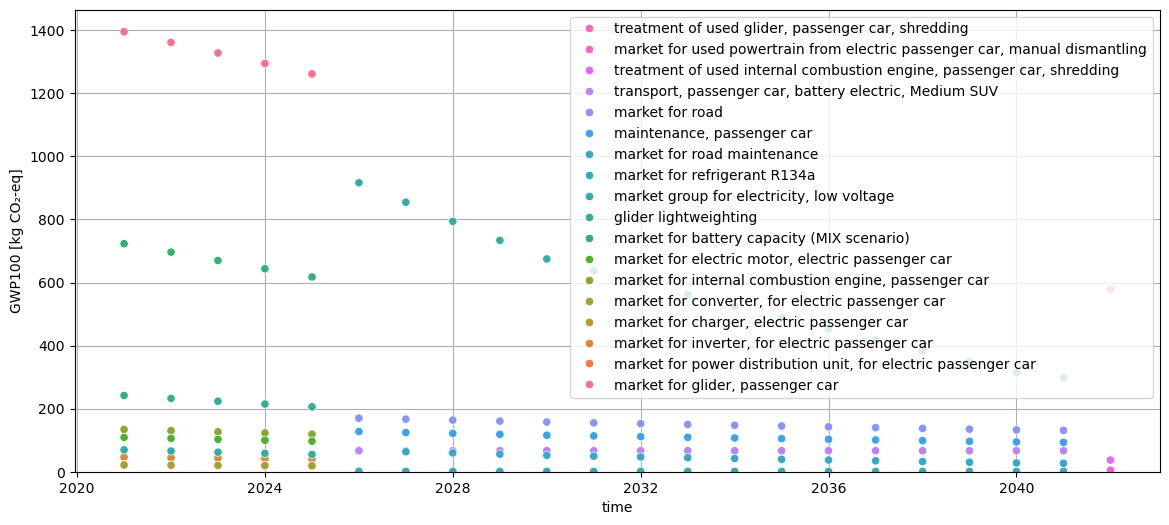

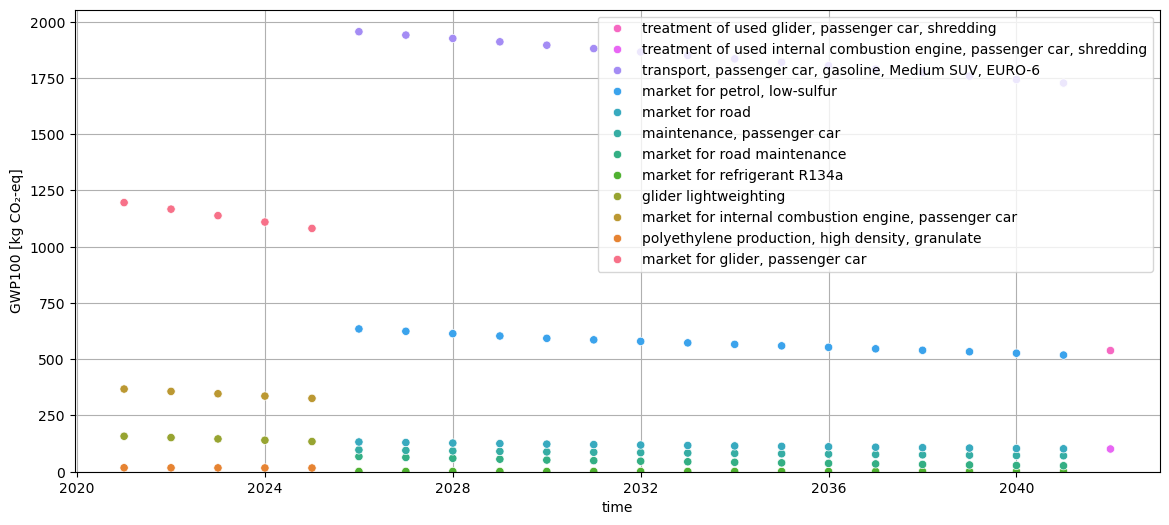

In [39]:
# As a first try we can use the integrated plotting function of timex
tlca_BEV.plot_dynamic_characterized_inventory(sum_emissions_within_activity=True, cumsum=False)
tlca_ICEC.plot_dynamic_characterized_inventory(sum_emissions_within_activity=True, cumsum=False)

In [ ]:
# Now this does not seem to be great because of the many processes, so maybe we can group them into categories
# and plot those instead...


In [43]:
[exc for exc in driving_icec.technosphere()]

[Exchange: 7.640378498763312e-06 unit 'maintenance, passenger car' (unit, RER, None) to 'transport, passenger car, gasoline, Medium SUV, EURO-6' (kilometer, RER, None)>,
 Exchange: -1.4271368854679167e-05 kilogram 'market for brake wear emissions, passenger car' (kilogram, GLO, None) to 'transport, passenger car, gasoline, Medium SUV, EURO-6' (kilometer, RER, None)>,
 Exchange: 6.330434644041816e-06 kilogram 'market for refrigerant R134a' (kilogram, GLO, None) to 'transport, passenger car, gasoline, Medium SUV, EURO-6' (kilometer, RER, None)>,
 Exchange: 0.0008383162785321474 meter-year 'market for road' (meter-year, GLO, None) to 'transport, passenger car, gasoline, Medium SUV, EURO-6' (kilometer, RER, None)>,
 Exchange: 0.001290000043809414 meter-year 'market for road maintenance' (meter-year, RER, None) to 'transport, passenger car, gasoline, Medium SUV, EURO-6' (kilometer, RER, None)>,
 Exchange: -1.5723269825684838e-05 kilogram 'market for road wear emissions, passenger car' (kilo

## BONUS options:

- Use dynamic_lcia(use_disaggregated_lci=TRUE) to perform a contribution analysis on the background activities contributing to the impacts. (Note that this function can take a while), find a good way to visualize thi

- Adavanced: Use temporal distritbutions to modell a fleet (of changing composition). (hint a for a fleet some cars will live longer, some shorter. This can be modelled using a distribution for the usephase and the EoL)
    - Now you can also look at different impacts (e.g. metal demand for example and see the metal demand per year needed to build a fleet)

- How is the comparison if we replace the petrol consumption of the car with biofuel (e.g. this activity:  'petrol production, 85% ethanol by volume from biomass' (kilogram, CH, None)). And then what about if you include biogenic carbon emissions by using for example this method: ('ecoinvent-3.10',
  'IPCC 2021',
  'climate change: biogenic, including SLCFs',
  'global warming potential (GWP20)')




In [ ]:
db_2020_NPi.metadata